In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

In [4]:
train_df=train_df.sample(frac=0.02)

In [5]:
test_df=test_df.sample(frac=0.02)

In [6]:
train_df.shape, test_df.shape

((4000, 202), (4000, 201))

In [7]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
172212,train_172212,0,10.3687,3.7804,8.5036,9.1164,10.9905,-11.2245,4.8282,15.8429,...,0.2880,8.6330,-0.0707,9.5651,22.6890,-1.3634,8.5586,6.8578,15.9635,-8.0137
195563,train_195563,0,12.0062,-6.7854,7.0029,5.2939,8.3098,-12.8027,5.4212,17.8903,...,9.4023,7.7749,1.4374,2.0666,17.6930,2.3123,5.3959,10.7631,21.4181,7.0175
141697,train_141697,0,4.9974,0.6442,12.0433,8.9549,10.1382,-10.8972,6.6268,20.5790,...,3.4336,10.0835,2.4379,4.3614,12.0469,-1.5565,8.4857,7.6009,15.2204,4.3415
11577,train_11577,0,8.1876,7.0007,14.5394,8.1311,9.5619,-8.8410,6.7868,16.9666,...,3.9039,7.0508,3.5504,7.0111,15.0668,-1.4495,5.1872,8.5501,17.5519,2.1677
118173,train_118173,0,10.3889,-4.3281,10.0079,3.9148,10.8781,3.5158,4.8513,11.2542,...,3.3964,5.3486,5.0895,-2.3984,15.4571,0.1488,10.0558,9.5458,14.8031,12.3660


In [8]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
111742,test_111742,7.1017,-7.0226,8.8662,4.4112,12.9127,-8.3927,5.0562,20.7294,-5.7492,...,-2.0424,7.3302,2.2614,1.4137,14.5809,0.4343,-0.9775,8.0451,17.5427,1.9752
134584,test_134584,7.5326,-3.5924,9.5202,6.9907,11.8528,-9.9475,4.4712,18.4932,-0.1544,...,8.1326,9.3324,3.0095,-6.6260,18.7246,1.3412,-6.1256,9.4191,17.5112,-7.8832
171576,test_171576,11.9295,5.0319,12.2931,6.4719,9.3988,2.1542,7.0431,20.8070,4.2349,...,-3.3971,7.5152,3.6517,4.1056,19.5447,-1.0038,8.6398,8.5203,13.9277,8.4888
18248,test_18248,12.5517,-5.6769,10.6612,9.0976,7.3118,-7.1585,5.2158,16.5374,0.0121,...,7.8691,9.3100,2.0380,8.5298,13.2488,1.4744,-4.2166,9.1001,16.6001,-12.2388
168598,test_168598,5.2550,-5.7010,10.4170,4.3574,11.1402,4.2977,4.3163,15.1148,1.6831,...,1.0984,3.4144,2.7513,4.4794,18.6202,0.8962,-0.4968,9.5542,15.3902,-19.9531


In [9]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [10]:
missing_data(test_df)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [11]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.101000,10.679887,-1.643497,10.693089,6.790406,11.124402,-4.738295,5.389072,16.566263,0.253911,...,3.185891,7.315337,1.925283,3.462431,17.897179,-0.122319,2.330021,8.918595,15.883699,-3.309744
std,0.301366,3.052061,4.025690,2.615990,2.021904,1.634615,7.792491,0.865157,3.434691,3.343286,...,4.450573,2.926189,1.467666,3.984534,3.098593,1.425531,5.447600,0.914260,3.014243,10.417619
min,0.000000,1.582200,-13.361300,2.582500,0.930100,6.197200,-25.210500,2.912300,7.119500,-8.401900,...,-11.802600,-0.757300,-2.985400,-8.922900,10.343500,-4.911600,-12.711200,6.362600,7.394400,-34.895200
25%,0.000000,8.408650,-4.598000,8.687550,5.284950,9.895325,-10.853200,4.731750,13.952575,-2.409225,...,-0.048200,5.095900,0.896775,0.648650,15.582175,-1.154500,-1.742525,8.271475,13.819450,-11.184375
50%,0.000000,10.501350,-1.623650,10.555500,6.822500,11.196850,-4.459800,5.381650,16.490850,0.384650,...,3.174700,7.253000,1.889950,3.470200,17.777600,-0.147950,2.330400,8.904150,15.954350,-3.019350
75%,0.000000,12.775325,1.292575,12.543400,8.302150,12.325250,1.281350,5.988750,19.167275,2.955900,...,6.299325,9.345850,2.945725,6.342925,20.183625,0.832475,6.574300,9.611225,18.086050,4.640150
max,1.000000,19.379300,9.029800,18.000200,12.329700,15.991400,15.955100,7.935900,26.690400,9.482200,...,14.889400,16.409400,6.818100,15.168200,26.628500,3.764700,14.572400,11.728100,24.808000,24.249500


In [12]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,10.705145,-1.611127,10.744332,6.750937,11.056738,-4.991236,5.411349,16.523703,0.266786,7.571801,...,3.320239,7.496931,1.905329,3.358701,18.069424,-0.112999,2.291493,8.908916,15.821381,-3.561816
std,3.044459,4.065361,2.671047,2.058261,1.626571,7.641259,0.880935,3.449726,3.306510,1.226856,...,4.576824,3.048856,1.468831,3.976750,3.133932,1.429607,5.407538,0.921277,3.024829,10.362907
min,3.064200,-12.156100,3.299300,0.877800,6.382900,-25.770900,2.314800,8.152500,-8.701000,4.367200,...,-10.639500,-0.522400,-3.244600,-9.939200,10.382900,-4.617500,-11.180300,6.401900,7.142500,-33.058300
25%,8.453725,-4.722150,8.748900,5.188075,9.863450,-10.836050,4.762425,13.884425,-2.363250,6.623500,...,-0.012400,5.183350,0.889800,0.725100,15.711900,-1.136425,-1.967375,8.250775,13.825125,-11.492775
50%,10.616950,-1.635850,10.660800,6.783200,11.075150,-4.805050,5.370400,16.475350,0.322150,7.653800,...,3.373800,7.375150,1.873450,3.502600,18.099800,-0.153000,2.548450,8.887350,15.890200,-3.087850
75%,12.744025,1.425800,12.619650,8.341800,12.231275,0.644625,6.025450,19.000550,2.926450,8.563175,...,6.439900,9.455350,2.952625,6.158350,20.474600,0.840250,6.444875,9.583375,18.024375,4.636025
max,19.287500,8.401000,18.206400,13.142000,15.340100,15.676800,7.858800,26.713900,8.927400,10.913000,...,18.479400,16.256700,6.748700,16.241500,26.601800,3.486100,15.862700,11.542100,24.882800,22.402200


In [13]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

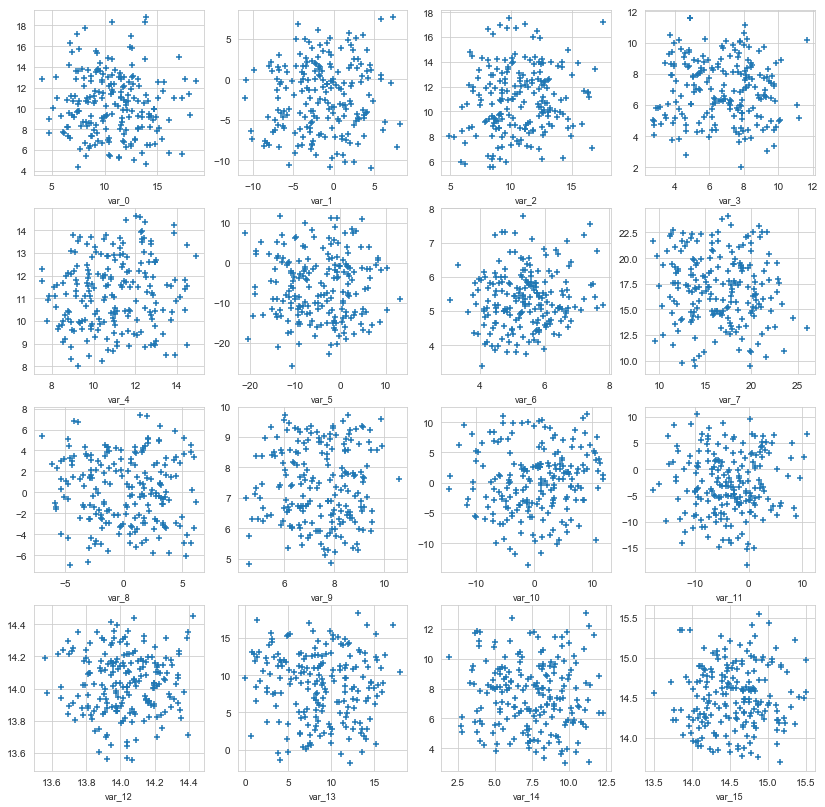

In [14]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df[::20],test_df[::20], features)

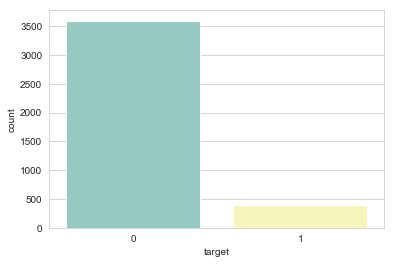

In [15]:
sns.countplot(train_df['target'], palette='Set3')

In [16]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 10.1% target values with 1


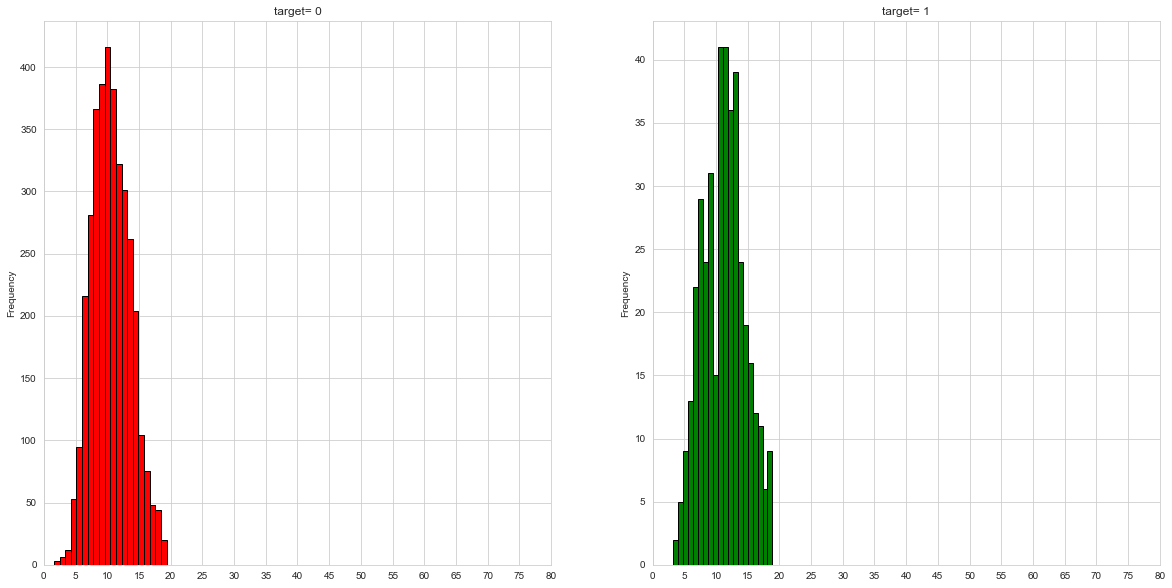

In [17]:
f,ax=plt.subplots(1,2,figsize=(20,10))
train_df[train_df['target']==0].var_0.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('target= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train_df[train_df['target']==1].var_0.plot.hist(ax=ax[1],color='green',bins=20,edgecolor='black')
ax[1].set_title('target= 1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

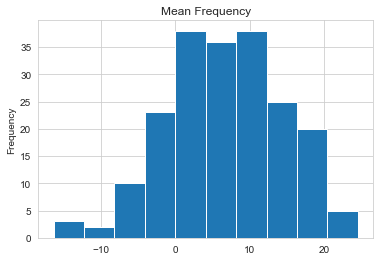

In [18]:
train_df[train_df.columns[2:]].mean().plot('hist');plt.title('Mean Frequency');

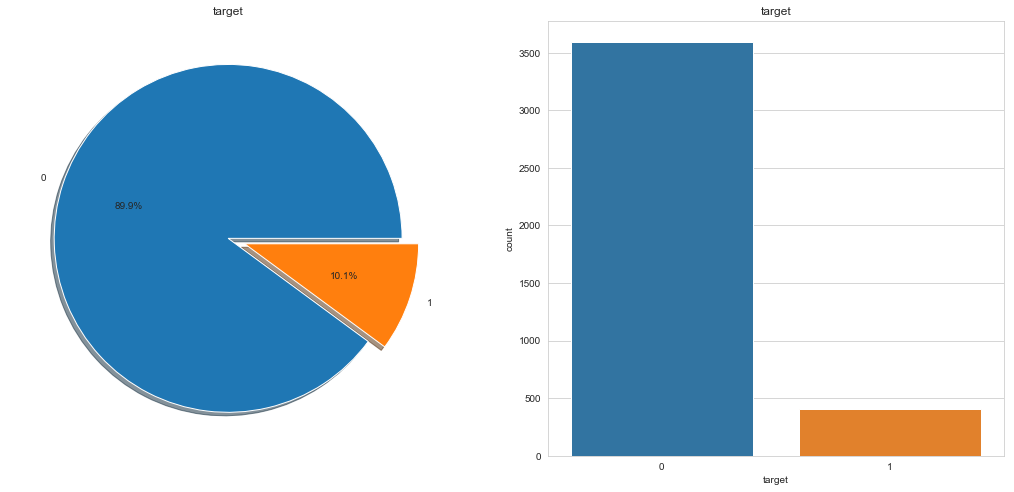

In [19]:
f,ax=plt.subplots(1,2,figsize=(18,8))
train_df['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot('target',data=train_df,ax=ax[1])
ax[1].set_title('target')
plt.show()

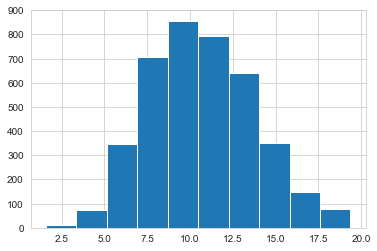

In [20]:
train_df["var_0"].hist();

In [21]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        # written by MJ Bahmani
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)
check_missing_data(train_df)

False

In [22]:
train_df['target'].unique()

array([0, 1], dtype=int64)

In [23]:
train_df['target'].value_counts()

0    3596
1     404
Name: target, dtype: int64

In [24]:
def check_balance(df,target):
    check=[]
    # written by MJ Bahmani for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('for target  {} ='.format(i))
        print(df[target].value_counts()[i]/df.shape[0]*100,'%')

In [25]:
check_balance(train_df,'target')

size of data is: 4000
for target  0 =
89.9 %
for target  1 =
10.100000000000001 %


In [26]:
print("Skewness: %f" % train_df['target'].skew())
print("Kurtosis: %f" % train_df['target'].kurt())

Skewness: 2.649264
Kurtosis: 5.021111


In [27]:
cols=["target","ID_code"]
X = train_df.drop(cols,axis=1)
y = train_df["target"]

In [28]:
X_test  = test_df.drop("ID_code",axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10)
lr = LinearRegression()
scoring = 'r2'
results = model_selection.cross_val_score(lr, X, y, cv=kfold, scoring=scoring)
lr.fit(X,y)
lr_predictions = lr.predict(X_test)
print('Coefficients: \n', lr.coef_,'\n')
print(results)
print(results.sum()/10)

Coefficients: 
 [ 4.17396075e-03  3.64648001e-03  6.10663303e-03  3.75836219e-03
 -4.53371598e-04  8.10091970e-04  1.95799845e-02  4.22157849e-03
  6.26657726e-04 -4.35028778e-03 -4.00727364e-04 -4.71710261e-04
 -5.57426749e-02 -2.41050148e-03 -4.55340468e-03  2.98592270e-02
  4.59145459e-04  6.88466609e-04  1.41048080e-03  3.64272667e-04
 -1.26741971e-03 -1.80775200e-03  6.72560119e-03 -2.52061902e-02
  2.85656067e-03 -4.85989956e-03  1.73972087e-03 -2.39010421e-03
 -2.01497584e-02 -3.93179208e-04  1.02848565e-04 -9.71253997e-04
  1.04826516e-03 -2.18011012e-03 -2.81068656e-02  3.13316566e-03
 -2.24741916e-03  8.81884537e-04  9.69637236e-05 -5.62671522e-04
  2.23655546e-03 -8.15640873e-04 -1.12606678e-02 -2.21792482e-02
 -3.17631368e-03  3.16871761e-05  1.46407911e-04 -2.58863042e-05
  1.23431405e-03  1.02443938e-03 -7.67608844e-03  5.36263300e-04
  1.04074823e-03  1.62604402e-02 -3.12518857e-04  1.65308548e-03
 -1.38557377e-03 -4.44989344e-03 -4.98560497e-04 -7.50266006e-03
  1.01124

In [31]:
from sklearn.metrics import r2_score
print("R_square score: ", r2_score(y_test,lr_predictions))

R_square score:  0.2682567195512986


In [32]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state = 42)
dtr.fit(X,y)
dtr_predictions = dtr.predict(X_test) 
results = model_selection.cross_val_score(dtr, X, y, cv=kfold, scoring='r2')
print(results)
print(results.sum()/10)

[-0.80523082 -1.01801802 -0.5671147  -1.1978022  -0.69370074 -0.62754304
 -1.37837838 -0.90998043 -0.59122416 -1.18086653]
-0.8969859005637171


In [33]:
print("R_square score: ", r2_score(y_test,dtr_predictions))

R_square score:  1.0


In [34]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')
clf.fit(X_train, y_train)
clf_predicitions = clf.predict(X_test) 
results = model_selection.cross_val_score(dtr, X, y, cv=kfold, scoring='r2')
print(results)
print(results.sum()/10)
print("R_square score: ", r2_score(y_test,clf_predicitions))

[-0.80523082 -1.01801802 -0.5671147  -1.1978022  -0.69370074 -0.62754304
 -1.37837838 -0.90998043 -0.59122416 -1.18086653]
-0.8969859005637171
R_square score:  0.0799477213544072


In [35]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train,y_train)
rfr_predicitions = rfr.predict(X_test) 
results = model_selection.cross_val_score(dtr, X, y, cv=kfold, scoring='r2')
print(results)
print(results.sum()/10)

[-0.80523082 -1.01801802 -0.5671147  -1.1978022  -0.69370074 -0.62754304
 -1.37837838 -0.90998043 -0.59122416 -1.18086653]
-0.8969859005637171


In [36]:
print("R_square score: ", r2_score(y_test,rfr_predicitions))

R_square score:  0.05563228777985085


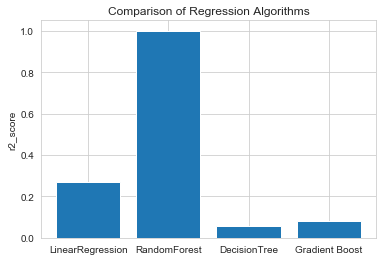

In [37]:
y = np.array([r2_score(y_test,lr_predictions),r2_score(y_test,dtr_predictions),r2_score(y_test,rfr_predicitions),
           r2_score(y_test,clf_predicitions)])
x = ["LinearRegression","RandomForest","DecisionTree","Gradient Boost"]
plt.bar(x,y)
plt.title("Comparison of Regression Algorithms")
plt.ylabel("r2_score")
plt.show()